<a href="https://colab.research.google.com/github/GirolamoOddo/ShoppingBuddy/blob/main/ShoppingBuddy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## __Set Environment__ (may take time)



---



In [ ]:
# @title Set environment [dev]
!git clone https://github.com/GirolamoOddo/ShoppingBuddy.git
!cp ./ShoppingBuddy/SBrequirements.txt ./

!python3 --version # 3.10.12
!pip install virtualenv
!virtualenv  ShoppingBuddyEnv
!source /content/ShoppingBuddyEnv/bin/activate; pip3 install -r SBrequirements.txt
!source /content/ShoppingBuddyEnv/bin/activate; pip3 list

import sys
sys.path.append("ShoppingBuddyEnv/lib/python3.10/site-packages")
print("Python is running from:", sys.prefix)


In [ ]:
# @title Import packages [dev]

import requests
from bs4 import BeautifulSoup
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageEnhance
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
import os
import zipfile

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet50_Weights
from googletrans import Translator

In [ ]:
# @title Code block [dev]

# Initialize the translator
translator = Translator()

# Utility web-scraping & image processing functions

def fetch_product_data(urls):
    """Fetch product data from a list of URLs and return a combined list of product dictionaries."""
    products = []
    for url in urls:
        segments = url.split('/')
        site_lang = segments[4]
        print(f"Collecting items from: {url}")

        response = requests.get(url)
        html_content = response.text
        soup = BeautifulSoup(html_content, 'html.parser')

        # Info: in order to find the information like: ProductImage_imageWrapper__dcoT9 for other web-site
        # open Chrome go to the website you would like to take items, press right button on the main page and
        # use the inspect feature, then go to 'Network' page, reload the website and check if there is a document
        # there you have to find the pattern that the site use to call the product images.
        product_wrappers = soup.find_all('div', class_='ProductImage_imageWrapper__dcoT9')
        for wrapper in product_wrappers:
            img_tag = wrapper.find('img')
            if img_tag:
                description = img_tag.get('alt')
                img_url = img_tag.get('src')
                translated_description = translator.translate(description, src=site_lang, dest='en').text

                ## this is a Mango web site specific detail to grab only -without model images-
                if 'without model' in translated_description.lower():
                    products.append({'description': translated_description.lower(), 'image_url': img_url})
    return products

def preprocess_image(image_url):
    """Fetch and preprocess an image from a URL."""
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).convert('L')  # Convert to grayscale
    # Increase contrast & sharpness
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(1.1)
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(1.1)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    img_tensor = transform(img)
    return img_tensor

def analyze_fit_rate_distribution(root_dir='labeled_dataset'):
    """Analyze the distribution of fit rates in the labeled dataset."""
    fit_rates = []

    # Collect fit rates from labeled dataset
    for fit_rate_dir in os.listdir(root_dir):
        fit_rate_path = os.path.join(root_dir, fit_rate_dir)
        if os.path.isdir(fit_rate_path):
            fit_rate = float(fit_rate_dir)
            fit_rates.extend([fit_rate] * len(os.listdir(fit_rate_path)))

    if not fit_rates:
        print("No fit rates found in the dataset.")
        return

    # Convert fit rates to numpy array for statistical operations
    fit_rates = np.array(fit_rates)

    mean_fit_rate = np.mean(fit_rates)
    std_fit_rate = np.std(fit_rates)
    min_fit_rate = np.min(fit_rates)
    max_fit_rate = np.max(fit_rates)

    print(f"Mean Fit Rate: {mean_fit_rate:.2f}")
    print(f"Standard Deviation of Fit Rate: {std_fit_rate:.2f}")
    print(f"Minimum Fit Rate: {min_fit_rate:.2f}")
    print(f"Maximum Fit Rate: {max_fit_rate:.2f}")

    # Assess if distribution is far from uniform
    if std_fit_rate > 0.35 and 0.45 <= mean_fit_rate <= 0.65:
        print("Your training set distribution appears relatively uniform.")
    else:
        print("Your training set distribution is far from uniform, so your model may presents biases.")

# Function to build the dataset
def build_dataset(urls):

    def show_image(image, title):
        """Display an image."""
        img = np.transpose(image.numpy(), (1, 2, 0))  # Convert to (H, W, C) for display
        plt.imshow(img, cmap='gray')  # Display in grayscale
        plt.title(title)
        plt.axis('off')
        plt.show()

    def create_labeled_dataset(products):
        """Create a labeled dataset from product images and save them in categorized folders based on fit rate."""
        base_dir = 'labeled_dataset'
        fit_rate_dirs = [f"{i/10:.1f}" for i in range(11)]
        if not os.path.exists(base_dir):
            os.makedirs(base_dir)
        for rate_dir in fit_rate_dirs:
            os.makedirs(os.path.join(base_dir, rate_dir), exist_ok=True)
        labeled_data = []
        def label_image(description, image_url):
            """Helper function to label an image and save it in the appropriate folder."""
            image = preprocess_image(image_url)
            show_image(image, description)
            fit_rate_widget = widgets.FloatSlider(
                value=0.5,
                min=0.0,
                max=1.0,
                step=0.1,
                description='Fit Rate:',
                continuous_update=False
            )
            def on_submit(change):
                fit_rate = round(fit_rate_widget.value, 1)
                fit_rate_dir = f"{fit_rate:.1f}"
                img_pil = transforms.ToPILImage()(image)
                safe_description = description.replace('/', '_').replace('\\', '_')
                image_path = os.path.join(base_dir, fit_rate_dir, f"{safe_description}.png")
                img_pil.save(image_path, format='PNG')
                labeled_data.append({
                    'description': description,
                    'image_path': image_path,
                    'fit_rate': fit_rate,
                    'image_url': image_url
                })
                clear_output(wait=True)
                if len(labeled_data) < len(products):
                    display_next_image()
                else:
                    print("All images labeled.")
                    clear_output(wait=True)
                    zip_file_path = 'labeled_dataset.zip'
                    with zipfile.ZipFile(zip_file_path, 'w') as zipf:
                        for root, dirs, files in os.walk(base_dir):
                            for file in files:
                                file_path = os.path.join(root, file)
                                zipf.write(file_path, os.path.relpath(file_path, base_dir))
                    print("Labeled dataset folder zipped and ready for download.")
                    from google.colab import files
                    files.download(zip_file_path)
            display(fit_rate_widget)
            fit_rate_widget.observe(on_submit, names='value')

        def display_next_image():
            """Display the next image and prompt for labeling."""
            if len(labeled_data) < len(products):
                product = products[len(labeled_data)]
                label_image(product['description'], product['image_url'])
        display_next_image()

    # URLs for fetching product data
    products = fetch_product_data(urls)
    create_labeled_dataset(products)

# Function to train the model
def train_model():
    class ProductDataset(Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            self.data = self._load_data()

        def _load_data(self):
            data = []
            for fit_rate_dir in os.listdir(self.root_dir):
                fit_rate_path = os.path.join(self.root_dir, fit_rate_dir)
                if os.path.isdir(fit_rate_path):
                    fit_rate = float(fit_rate_dir)
                    for img_name in os.listdir(fit_rate_path):
                        img_path = os.path.join(fit_rate_path, img_name)
                        if img_name.endswith(('.png', '.jpg', '.jpeg')):
                            data.append((img_path, fit_rate))
            return data

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            img_path, fit_rate = self.data[idx]
            image = Image.open(img_path).convert('L')  # Convert to grayscale
            if self.transform:
                image = self.transform(image)
            return image, fit_rate

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    train_dataset = ProductDataset('labeled_dataset', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    num_ftrs = resnet50.fc.in_features

    # Modify the first convolutional layer to accept single-channel (grayscale) images
    resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    resnet50.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )

    device = torch.device('cpu')  # Use 'cuda' if GPU is available
    resnet50 = resnet50.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

    resnet50.train()
    for epoch in range(5):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = resnet50(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

    torch.save(resnet50.state_dict(), 'resnet50_fitrates.pth')

# Function to use the model for predictions
def use_model(urls, lang='en'):

    def predict_fit_rate(model, products):
        """Predict the fit-rate for each product and return a ranked list of products with their links."""
        model.eval()
        results = []
        with torch.no_grad():
            for product in products:
                img_tensor = preprocess_image(product['image_url']).unsqueeze(0)  # Add batch dimension
                fit_rate = model(img_tensor).item()
                product['fit_rate'] = fit_rate
                results.append(product)
        results.sort(key=lambda x: x['fit_rate'], reverse=True)
        return results

    resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    num_ftrs = resnet50.fc.in_features

    resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    resnet50.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )
    resnet50.load_state_dict(torch.load('resnet50_fitrates.pth'))
    resnet50.eval()

    products = fetch_product_data(urls)
    ranked_products = predict_fit_rate(resnet50, products)

    for product in ranked_products:
        translated_description = translator.translate(product['description'], src='en', dest=lang).text.lower() if lang != 'en' else product['description']

        # Set column widths for better alignment
        description_col_width = 60
        fit_rate_col_width    = 10
        link_col_width        = 70

        truncated_description = (translated_description[:description_col_width - 3] + '...') if len(translated_description) > description_col_width else translated_description

        # Print the formatted output with fixed-width columns
        print(f"Description: {truncated_description:<{description_col_width}} "
              f"Fit-Rate: {np.round(product['fit_rate'], 2):<{fit_rate_col_width}} "
              f"Link: {product['image_url']:<{link_col_width}}")


## __User Pipeline__



---



## __1) Build your dataset__
Here you heve only to select the items based on your tastes from the slider under the image.  
To start the process run the code cell below.  

After the process the dataset will be saved in your machine, store it properly.

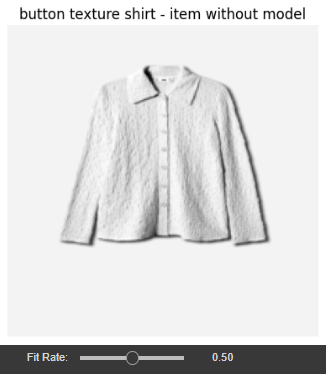

In [ ]:
# @title 1. Build your dataset [code]

# Usage:
# 1. Build dataset (this take time):
url_1 = 'https://www.mangooutlet.com/it/it/c/donna/bluse-e-camicie_b8003173?range=2.00-100.00'
url_2 = 'https://www.mangooutlet.com/it/it/c/donna/pantaloni_bf28b3b?range=2.00-100.00'
url_3 = 'https://www.mangooutlet.com/it/it/c/donna/gonne_a1a0d939?range=2.00-100.00'
url_4 = 'https://www.mangooutlet.com/it/it/c/donna/jeans_bda1aa43?range=2.00-100.00'
url_5 = 'https://www.mangooutlet.com/it/it/c/donna/cappotti_d1b967bc?range=24.00-200.00'
url_6 = 'https://www.mangooutlet.com/it/it/c/donna/giacche_5ef3ad3b?range=5.00-100.00'

train_urls = [url_1, url_2, url_3, url_4, url_5, url_6]
build_dataset(train_urls)



--



## __2) Train the model__

Now you have to train the model with your taste, so run the cell below to start the training.

After the training the model will be saved in your machine, store it properly.


In [ ]:
# @title 2. Train the model [code]
# 2. Train the model:
# be sure to have the labeled_dataset folder and the
# resnet50_fitrates.pth trained torch model in the working dir
analyze_fit_rate_distribution()
train_model()

from google.colab import files
files.download('resnet50_fitrates.pth')


Mean Fit Rate: 0.21
Standard Deviation of Fit Rate: 0.20
Minimum Fit Rate: 0.00
Maximum Fit Rate: 0.70
Your training set distribution is far from uniform, so your model may presents biases.
Epoch 1, Loss: 0.08481468912214041
Epoch 2, Loss: 0.03475695475935936
Epoch 3, Loss: 0.053469701670110226
Epoch 4, Loss: 0.03249920625239611
Epoch 5, Loss: 0.040558069944381714


--

## 3) __Use the model__    

Now go to Mango or Mango Outlet site, select the category of garments, and apply the filters you prefer and copy the link in the box below and run.   

Please before running the cell below be sure to have the model in your working directory (left menu, last icon, file: resnet50_fitrates.pth) if not please train a new model (step 1 and 2) or drag-&-drop a trained model in to the working dir.  


In [ ]:
# @title __3. Use the model__
# 3. Use the model for predictions:
# be sure to have the resnet50_fitrate.pth traine torch model in the working dir
pred_urls = ['https://www.mangooutlet.com/it/it/c/donna/cappotti_d1b967bc']
use_model(pred_urls, lang='en')


Description: padded down jacket with pockets - article without model      Fit-Rate: 0.03       Link: https://www.mangooutlet.com/assets/rcs/pics/static/T3/fotos/S/37034377_30_B.jpg?ts=1669138689479&im=SmartCrop,width=2048,height=2867.2&imdensity=1
Description: long padded down jacket - item without model                 Fit-Rate: 0.01       Link: https://www.mangooutlet.com/assets/rcs/pics/static/T3/fotos/S/37005132_99_B.jpg?ts=1669291390906&im=SmartCrop,width=2048,height=2867.2&imdensity=1
Description: double buttoned wool coat - article without model            Fit-Rate: 0.01       Link: https://www.mangooutlet.com/assets/rcs/pics/static/T5/fotos/S/57089114_91_B.jpg?ts=1696926774943&im=SmartCrop,width=2048,height=2867.2&imdensity=1
Description: waterproof parka with internal down jacket - article with... Fit-Rate: 0.0        Link: https://www.mangooutlet.com/assets/rcs/pics/static/T3/fotos/S/37067715_09_B.jpg?ts=1663750449929&im=SmartCrop,width=2048,height=2867.2&imdensity=1
Descript